# LungsNet: Model Evaluation
This notebook provides detailed metrics for the trained LungsNet model, satisfying the **Evaluation** requirement of the Data Mining process.

## Metrics Covered:
1.  **Confusion Matrix**
2.  **Classification Report** (Precision, Recall, F1-Score)
3.  **ROC-AUC Curve**
4.  **Sensitivity & Specificity Analysis**
5.  **Grad-CAM Visualization** (Explainability)

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2

# Set Style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Load Model & Test Data
Note: The model loaded here was trained on the augmented, balanced dataset.

In [3]:
MODEL_PATH = '../models/lungsnet_densenet121.h5'
DATA_DIR = "../data/raw/chest_xray"
TEST_DIR = os.path.join(DATA_DIR, "test")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load Model
if os.path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✅ Model loaded successfully.")
else:
    print("❌ Model not found! Please train the model first.")

# Data Generator for Test Set (No Augmentation, just Rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # IMPORTANT: Do not shuffle to match predictions with labels
)

✅ Model loaded successfully.
Found 624 images belonging to 2 classes.


## 2. Generate Predictions

In [4]:
print("Generating predictions...")
predictions = model.predict(test_generator, verbose=1)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

print(f"Predictions shape: {y_pred.shape}")
print(f"True labels shape: {y_true.shape}")

Generating predictions...
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step 
Predictions shape: (624,)
True labels shape: (624,)


## 3. Confusion Matrix

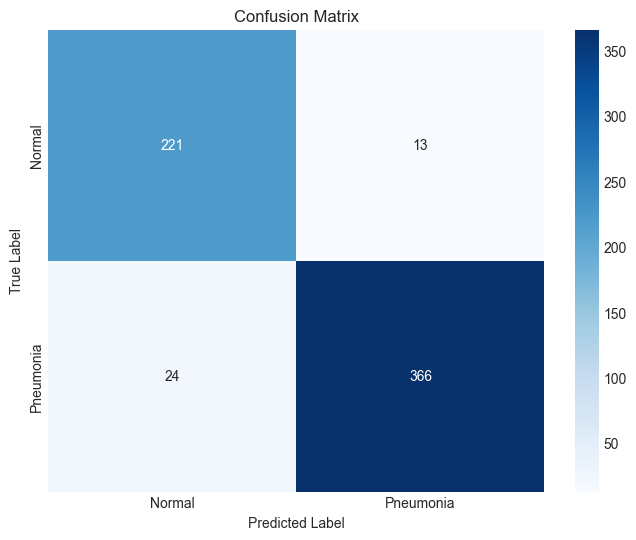

In [21]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 4. Classification Report

In [22]:
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.90      0.94      0.92       234
   Pneumonia       0.97      0.94      0.95       390

    accuracy                           0.94       624
   macro avg       0.93      0.94      0.94       624
weighted avg       0.94      0.94      0.94       624



## 5. ROC-AUC Curve

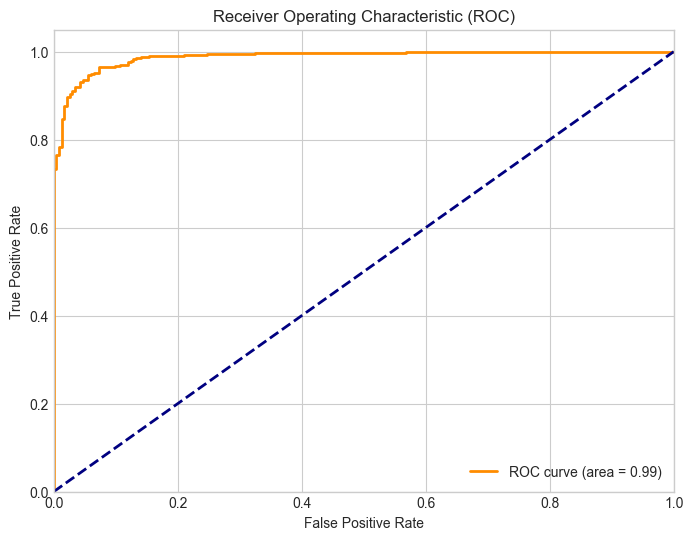

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## 6. Explainability (Grad-CAM)
Visualize where the model is looking using Gradient-weighted Class Activation Mapping.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


d:\Tugas kuliah\SEM 5\UAS\BigDataMining\LungsNet\venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_2']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\VICTUS\AppData\Local\Temp\ipykernel_13964\2783964631.py:40: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


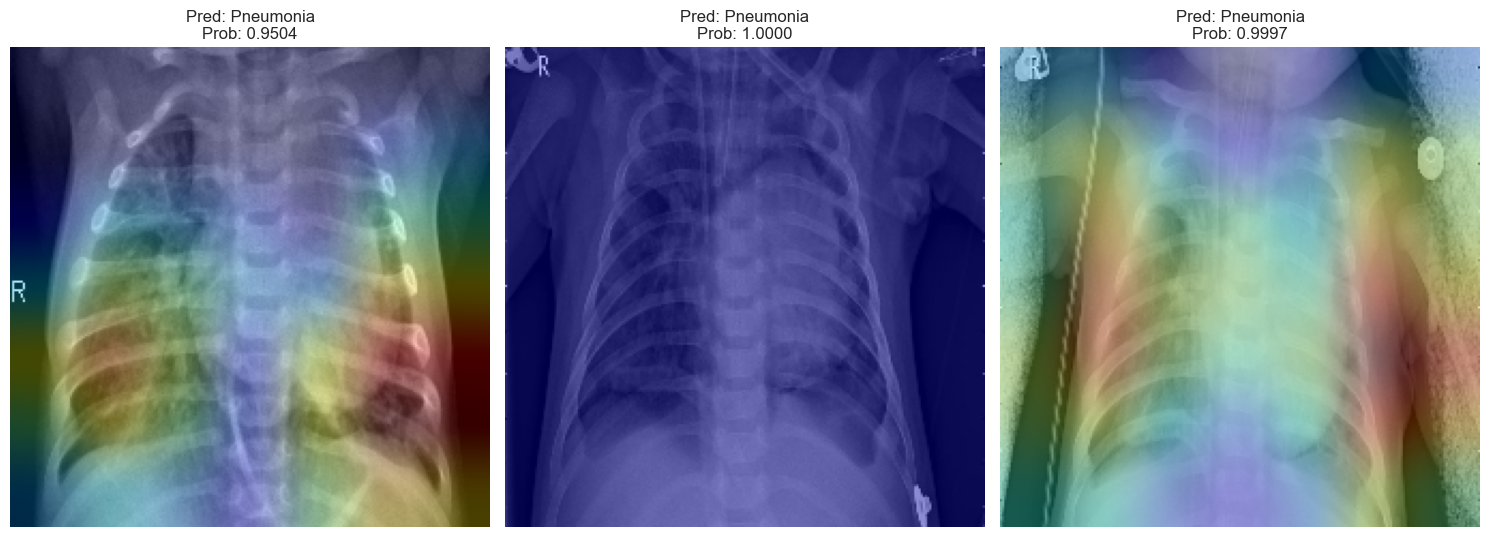

In [5]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

# --- Settings ---
LAST_CONV_LAYER = 'conv5_block16_concat' # Standard for DenseNet121

# Select a few random Pneumonia images from test set
if os.path.exists(os.path.join(TEST_DIR, 'PNEUMONIA')):
    pneumonia_samples = os.listdir(os.path.join(TEST_DIR, 'PNEUMONIA'))[:3]

    plt.figure(figsize=(15, 10))

    for i, img_name in enumerate(pneumonia_samples):
        img_path = os.path.join(TEST_DIR, 'PNEUMONIA', img_name)
        
        # Preprocess
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        
        # Prediction
        preds = model.predict(img_array)
        is_pneumonia = preds[0][0] > 0.5
        
        # Generate Heatmap
        try:
            heatmap = make_gradcam_heatmap(img_array, model, LAST_CONV_LAYER)
            result_img = display_gradcam(img_path, heatmap)
            
            plt.subplot(1, 3, i+1)
            plt.imshow(result_img)
            plt.title(f"Pred: {'Pneumonia' if is_pneumonia else 'Normal'}\nProb: {preds[0][0]:.4f}")
            plt.axis('off')
        except Exception as e:
            print(f"Error generating Grad-CAM for {img_name}: {e}")
            print("Tip: Verify layer name using model.summary()")

    plt.tight_layout()
    plt.show()

Jumlah kasus False Negative: 24


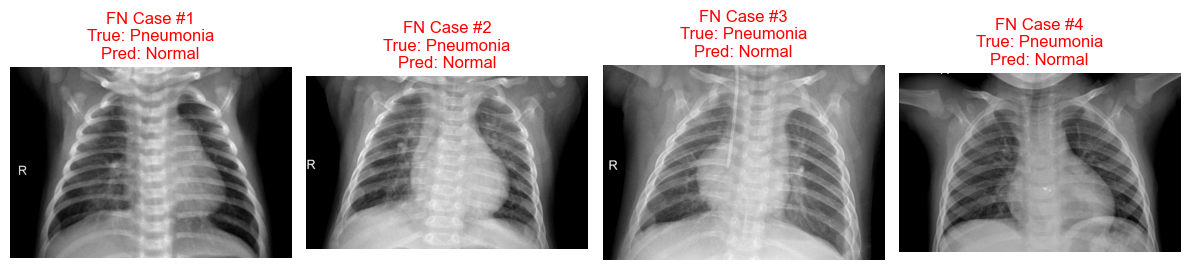

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Pastikan y_true dan y_pred sudah ada dari cell sebelumnya
# y_true = label asli (0: Normal, 1: Pneumonia)
# y_pred = hasil prediksi model (0: Normal, 1: Pneumonia)

# 1. Cari indeks False Negative (FN)
# FN adalah saat Asli = 1 (Pneumonia), tapi Prediksi = 0 (Normal)
fn_indices = [i for i, (real, pred) in enumerate(zip(y_true, y_pred)) if real == 1 and pred == 0]

print(f"Jumlah kasus False Negative: {len(fn_indices)}")

# 2. Tampilkan maksimal 4 kasus kegagalan
num_images = min(len(fn_indices), 4)

if num_images > 0:
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        idx = fn_indices[i]
        
        # Ambil gambar dari generator
        # Note: test_generator[idx] mungkin perlu disesuaikan tergantung batch
        # Cara aman: ambil filename dari generator
        filename = test_generator.filenames[idx]
        img_path = os.path.join(TEST_DIR, filename)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.title(f"FN Case #{i+1}\nTrue: Pneumonia\nPred: Normal", color='red')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Hebat! Model Anda tidak memiliki False Negative (Perfect Recall).")